Best experiment: trial_03_hs48_dr0.156_lr1e-04/training_log.csv (val_rmse=0.0276)


Running test on validation cell: MGFarm_18650_C07, 1449438 samples
Test MAE: 0.0463, RMSE: 0.0479
Test MAE: 0.0463, RMSE: 0.0479
Plot saved to trial_03_hs48_dr0.156_lr1e-04/final_test_plot.png
Plot saved to trial_03_hs48_dr0.156_lr1e-04/final_test_plot.png


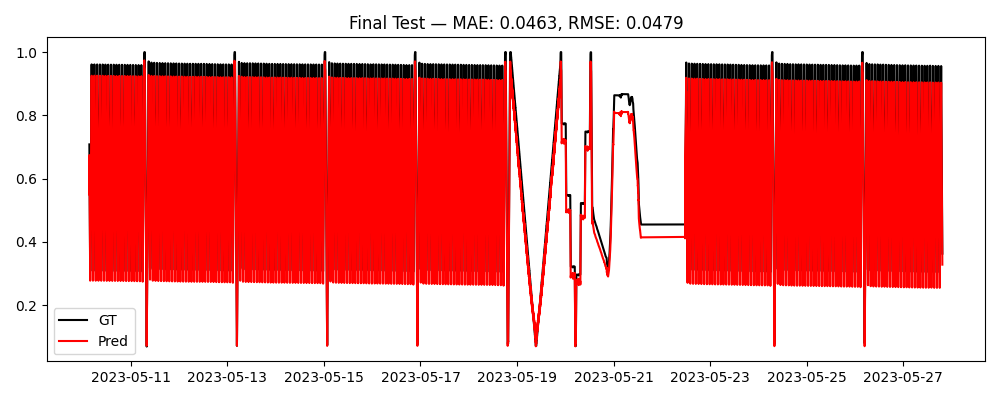

In [4]:
import os
import sys
import argparse
from pathlib import Path
import re

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

# --- begin standalone device/model/data definitions ---

# device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# load_data (copy/adapted from HPT)
def load_data(base_path: str = "/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes"):
    base = Path(base_path)
    cells = {}
    for folder in sorted(base.iterdir()):
        if folder.is_dir() and folder.name.startswith("MGFarm_18650_"):
            dfp = folder / "df.parquet"
            if dfp.exists():
                cells[folder.name] = pd.read_parquet(dfp)
    # train/val split names
    train_cells = ["MGFarm_18650_C05","MGFarm_18650_C01","MGFarm_18650_C21","MGFarm_18650_C19"]
    val_cell     = "MGFarm_18650_C07"
    feats = ["Voltage[V]","Current[A]","SOH_ZHU","Q_m"]
    # fit scaler
    df_all = pd.concat([cells[n] for n in train_cells], ignore_index=True)
    from sklearn.preprocessing import MaxAbsScaler
    scaler = MaxAbsScaler().fit(df_all[feats])
    # scale train
    train_scaled = {}
    for n in train_cells:
        df = cells[n].copy()
        df['timestamp'] = pd.to_datetime(df['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
        df[feats] = scaler.transform(df[feats])
        train_scaled[n] = df
    # prepare val/test
    df3 = cells[val_cell].copy()
    df3['timestamp'] = pd.to_datetime(df3['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
    L = len(df3); i1,i2 = int(L*0.5), int(L*0.6)
    df_val  = df3.iloc[:i1].copy();  df_test = df3.iloc[i1:i2].copy()
    df_val[feats]  = scaler.transform(df_val[feats])
    df_test[feats] = scaler.transform(df_test[feats])
    return train_scaled, df_val, df_test, train_cells, val_cell

# init_hidden helper
def init_hidden(model, batch_size=1, device=None):
    if device is None:
        device = next(model.parameters()).device
    h = torch.zeros(model.lstm.num_layers, batch_size, model.lstm.hidden_size, device=device)
    c = torch.zeros_like(h)
    return h, c

# weight init
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for n, p in m.named_parameters():
            if 'weight' in n: nn.init.xavier_uniform_(p)
            elif 'bias' in n:   nn.init.constant_(p, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight); nn.init.constant_(m.bias, 0)

# build_model (from HPT)
def build_model(input_size=4, hidden_size=32, num_layers=1, dropout=0.2, mlp_hidden=32):
    class SOCModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.0)
            self.mlp  = nn.Sequential(
                nn.Linear(hidden_size, mlp_hidden),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(mlp_hidden, 1),
                nn.Sigmoid()
            )
        def forward(self, x, hidden):
            self.lstm.flatten_parameters()
            h, c = hidden
            out, (h, c) = self.lstm(x.contiguous(), (h.contiguous(), c.contiguous()))
            b, seq, hid = out.size()
            flat = out.contiguous().view(b*seq, hid)
            soc  = self.mlp(flat).view(b, seq)
            return soc, (h, c)
    model = SOCModel().to(device)
    model.apply(init_weights)
    model.lstm.flatten_parameters()
    return model

# evaluate_onechunk_seq2seq (from HPT)
def evaluate_onechunk_seq2seq(model, df, device):
    seq    = df[["Voltage[V]","Current[A]","SOH_ZHU","Q_m"]].values
    labels = df["SOC_ZHU"].values
    h, c   = init_hidden(model, batch_size=1, device=device)
    chunk  = torch.tensor(seq, dtype=torch.float32, device=device).unsqueeze(0).contiguous()
    with torch.no_grad():
        model.lstm.flatten_parameters()
        with torch.backends.cudnn.flags(enabled=False):
            out, _ = model(chunk, (h, c))
    preds = out.squeeze(0).cpu().numpy()
    mse   = np.mean((preds - labels)**2)
    return mse, preds, labels

# --- end standalone definitions ---

def find_best_experiment(base_dir: Path):
    best = (float('inf'), None, None)  # (val_rmse, csv_path, exp_dir)
    for csv_path in base_dir.rglob("*.csv"):
        try:
            df = pd.read_csv(csv_path)
        except:
            continue
        if 'val_rmse' not in df.columns:
            continue
        min_val = df['val_rmse'].min()
        if min_val < best[0]:
            best = (min_val, csv_path, csv_path.parent)
    return best

def main():
    p = argparse.ArgumentParser(
        description="Select best model by val_rmse from all CSVs and run final test"
    )
    p.add_argument(
        "--base-dir", "-b",
        type=Path,
        default=Path("."),
        help="root folder to search for *.csv"
    )
    args, _ = p.parse_known_args()   # ignore unknown Jupyter kernel args

    val_rmse, csv_path, exp_dir = find_best_experiment(args.base_dir)
    if exp_dir is None:
        print("No CSV with 'val_rmse' found under", args.base_dir)
        sys.exit(1)

    print(f"Best experiment: {csv_path} (val_rmse={val_rmse:.4f})")
    pth = exp_dir / "best_seq2seq_soc.pth"
    if not pth.exists():
        print("ERROR: model file not found:", pth)
        sys.exit(1)

    # load test data
    _, _, df_test, _, val_cell = load_data()
    print(f"Running test on validation cell: {val_cell}, {len(df_test)} samples")

    # --- extract hyperparameters from experiment folder name ---
    # expects something like "..._hs48_dr0.156_lr1e-04"
    match = re.search(r"hs(?P<hs>\d+)_dr(?P<dr>[0-9.]+)", exp_dir.name)
    if match:
        hidden_size = int(match.group("hs"))
        dropout     = float(match.group("dr"))
    else:
        hidden_size, dropout = 32, 0.2  # fallbacks

    # build & load model with correct size/dropout
    model = build_model(hidden_size=hidden_size, dropout=dropout)
    sd = torch.load(pth, map_location=device, weights_only=True)
    if 'state_dict' in sd:
        model.load_state_dict(sd['state_dict'])
    else:
        model.load_state_dict(sd)
    model.to(device).eval()

    # run one‐chunk seq2seq test
    mse, preds, labels = evaluate_onechunk_seq2seq(model, df_test, device)
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(preds - labels)))

    print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # save plot
    ts = pd.to_datetime(df_test['timestamp'])
    plt.figure(figsize=(10,4))
    plt.plot(ts, labels, 'k-', label="GT")
    plt.plot(ts, preds,  'r-', label="Pred")
    plt.title(f"Final Test — MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    plt.legend()
    plt.tight_layout()
    out_png = exp_dir / "final_test_plot.png"
    plt.savefig(out_png)
    print("Plot saved to", out_png)

if __name__ == "__main__":
    main()